In [1]:
import numpy as np
import pickle as pkl
import pandas as pd
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import os
import tol_colors as tc
from pathlib import Path

# Berechnung

Transformation IMU-Orientierung ins OpenSim KS

$$^{IMU}_{OpenSim}T = ^{OpenSim_y}_{OpenSim}T*^{XKF3hm}_{OpenSim_y}T*^{IMU}_{XKF3hm}T$$

Berechnung der Orientierung zwischen IMU und Marker im OpenSim KS
$$^{IMU}_{Marker}T = ^{OpenSim}_{Marker}T* ^{IMU}_{OpenSim}T$$

Berechnung der Abweichung zwischen IMU und Marker
$$ ^{IMU}_{Marker}T -> AxisAngle -> ||AxisAngle||$$





In [2]:
cset = tc.tol_cset('bright')

/var/folders/4p/kn7q37fn23z2czb7rsw845080000gn/T/ipykernel_55014/3729869740.py:1: DeprecationWarning: tol_cset is soft-deprecated since 2.0, please use tol_colors.colorsets instead
  cset = tc.tol_cset('bright')


In [55]:
def plot_sample(data, subject_name, exercise_name):
    fig, axs = plt.subplots(3,3, figsize=(10,10), sharey=True, constrained_layout = True)
    axs = axs.flatten()
    for i,  (pos, d) in enumerate(data.items()):
        max_ind = len(d['deviations_angles'])
        deviations = d['deviations_angles']
        errors = list(set(d['error_indices']))
        errors = [x for x in errors if x < max_ind]
        deviations[errors] = 0.0
        axs[i].plot(deviations)
        # axs[i].plot(d['deviations_angles'])
        # axs[i].scatter(d['error_indices'], d['deviations_angles'][d['error_indices']], color='red', marker='x')
        axs[i].set_title(pos)
        axs[i].set_ylabel('Deviation in Degrees')
        axs[i].set_xlabel('Samples')
    fig.suptitle(f'Deviations for measurement {subject_name} - {exercise_name}')
    plt.show()


def plot_sample_w_offset(data, subject_name, exercise_name, offset):
    fig, axs = plt.subplots(3,3, figsize=(10,10), sharey=True, constrained_layout = True)
    axs = axs.flatten()
    for i,  (pos, d) in enumerate(data.items()):
        R_imu_marker = R.from_quat(d['marker_orientations'])
        R_imu = R.from_quat(d['imu_orientations'])

        q_diff = R_imu_marker[:len(R_imu_marker)-offset] * R_imu[offset:].inv()
        max_ind = len(d['deviations_angles'])
        deviations = np.linalg.norm(q_diff.as_rotvec(degrees=True), axis=1)
        # errors = list(set(d['error_indices']))
        # errors = [x for x in errors if x < max_ind]
        # deviations[errors] = 0.0
        axs[i].plot(deviations)
        # axs[i].plot(d['deviations_angles'])
        # axs[i].scatter(d['error_indices'], d['deviations_angles'][d['error_indices']], color='red', marker='x')
        axs[i].set_title(pos)
        axs[i].set_ylabel('Deviation in Degrees')
        axs[i].set_xlabel('Samples')
    fig.suptitle(f'Deviations for measurement {subject_name} - {exercise_name}')
    plt.show()

def plot_euler_angles(data, subject_name, exercise_name, start_ind, end_ind):
    fig, axs = plt.subplots(3,3, figsize=(15,10), constrained_layout = True)
    axs = axs.flatten()
    for i,  (pos, d) in enumerate(data.items()):
        deviations = d['deviations_angles']
        errors = list(set(d['error_indices']))
        deviations[errors] = 0.0
        time = np.arange(0, len(deviations))[start_ind:end_ind]

        axs[i].plot(time, deviations[start_ind:end_ind], color=cset.purple)

        ax1b = axs[i].twinx()
        marker_orientations = R.from_quat(d['marker_orientations']).as_euler('xyz', degrees=True)
        marker_orientations[errors, :] = [0.0, 0.0, 0.0]
        ax1b.plot(time, marker_orientations[start_ind:end_ind, 0], label='marker x', color=cset.red )
        ax1b.plot(time, marker_orientations[start_ind:end_ind, 1], label='marker y', color=cset.green)
        ax1b.plot(time, marker_orientations[start_ind:end_ind, 2], label='marker z', color=cset.blue)
        imu_orientations = R.from_quat(d['imu_orientations']).as_euler('xyz', degrees=True)
        imu_orientations[errors, :] = [0.0, 0.0, 0.0]
        ax1b.plot(time, imu_orientations[start_ind:end_ind, 0], label='imu x', linestyle='--', color=cset.red)
        ax1b.plot(time, imu_orientations[start_ind:end_ind, 1], label='imu y', linestyle='--', color=cset.green)
        ax1b.plot(time, imu_orientations[start_ind:end_ind, 2], label='imu z', linestyle='--', color=cset.blue)
        ax1b.set_ylabel('Euler Angle in Degrees')
        axs[i].set_title(pos)
        axs[i].set_ylabel('Deviation in Degrees')
        axs[i].set_xlabel('Samples')
    legend_elements = [plt.plot(0,0, color=cset.red, label='marker x')[0],
                          plt.plot(0,0, color=cset.green, label='marker y')[0],
                          plt.plot(0,0, color=cset.blue, label='marker z')[0],
                          plt.plot(0,0, linestyle='--', color=cset.red, label='imu x')[0],
                          plt.plot(0,0, linestyle='--', color=cset.green, label='imu y')[0],
                          plt.plot(0,0, linestyle='--', color=cset.blue, label='imu z')[0]]
    fig.legend(handles=legend_elements, loc='center', bbox_to_anchor=(0.5, -0.05))
    fig.suptitle(f'Deviations for measurement {subject_name} - {exercise_name}')
    plt.show()

def read_trc_file(filename):

    if not os.path.exists(filename):
        print('file does not exist')

    # read all lines
    file_id = open(filename, 'r')
    all_lines = file_id.readlines()
    file_id.close()

    marker_names = all_lines[3].split('\t')
    marker_names.remove('Frame#')
    marker_names.remove('Time')

    if '\n' in marker_names:
        marker_names.remove('\n')

    marker_names = [x for x in marker_names if x != '']
    col_names = ['Time']
    for m in marker_names:
        col_names.append(f'{m}_x')
        col_names.append(f'{m}_y')
        col_names.append(f'{m}_z')

    data = []
    line_idx = 5
    while line_idx < all_lines.__len__():
        d = all_lines[line_idx].split('\t')[1:]
        if len(d) != len(col_names):
            raise ValueError(f'Number of columns in line {line_idx} does not match number of marker columns')
        data.append(d)
        line_idx += 1

    measured_data = pd.DataFrame(data=data['deviations_angles'], columns=col_names).astype('float', errors='ignore')
    return measured_data

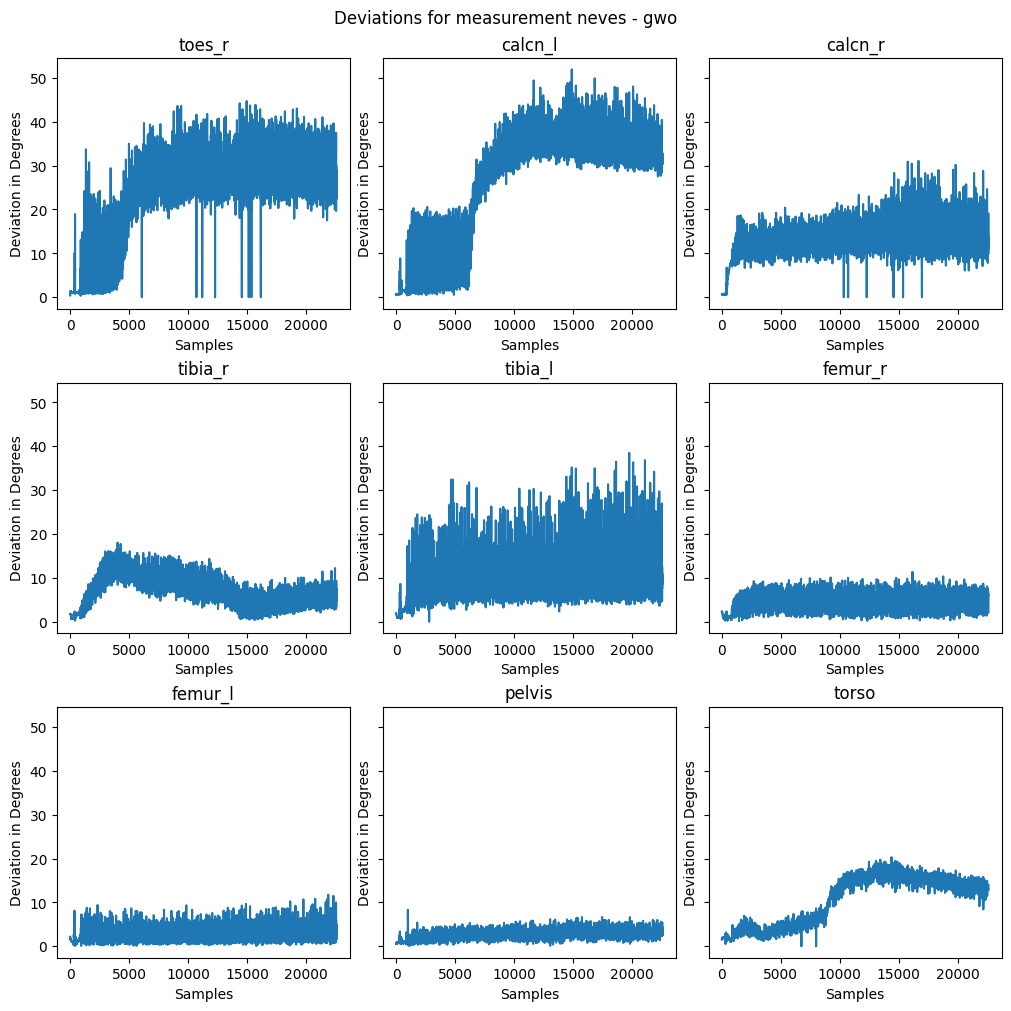

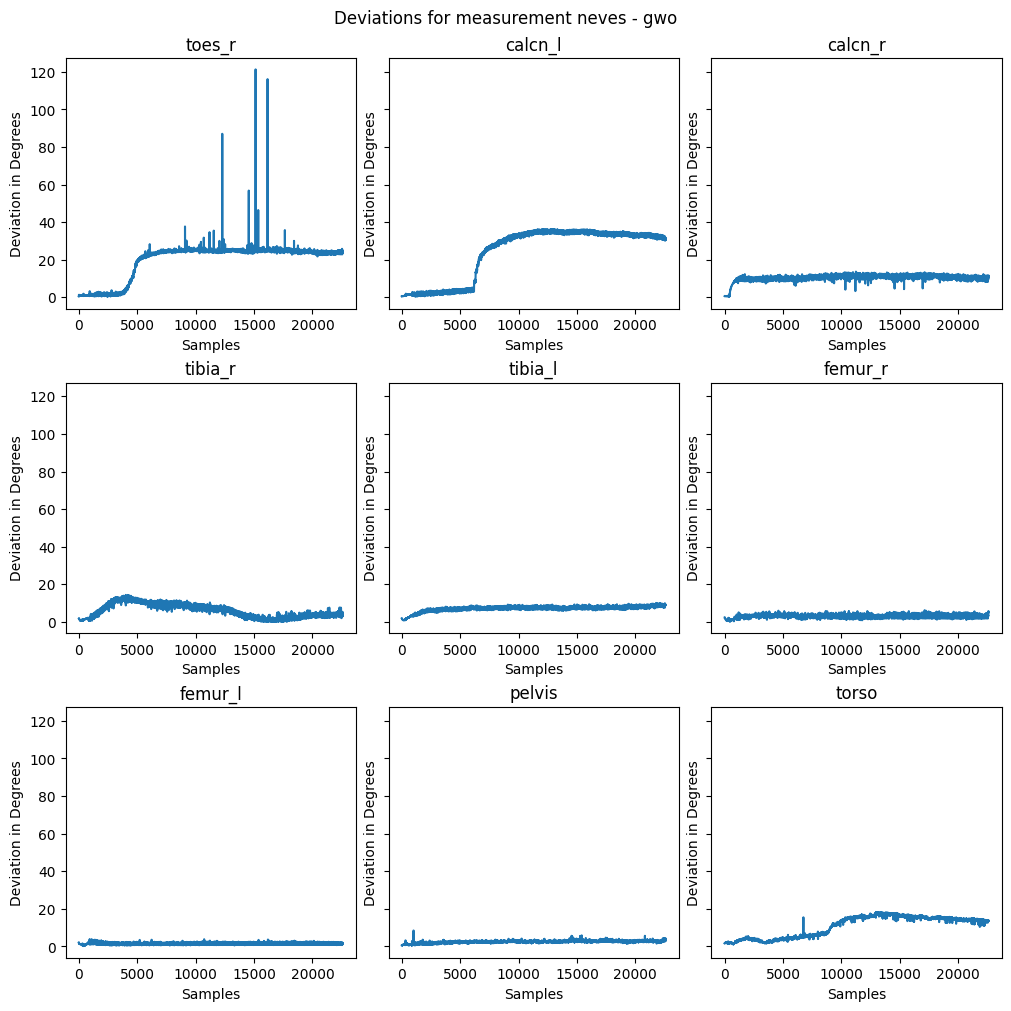

In [70]:
base_path = Path('/Users/andi/Downloads/Data')

subject_name = 'neves'
exercise_name = 'gwo'

data_path = base_path / subject_name / exercise_name
data = pkl.load(open(data_path / 'imu_marker_deviations_second_version.pkl', 'rb'))
plot_sample(data, subject_name, exercise_name)
plot_sample_w_offset(data, subject_name, exercise_name, 3)
# other possibilities: darryl, elodie, erna, etsuko
# subject_names = ['austra', 'darryl', 'elodie', 'erna', 'etsuko', 'gregers', 'hamit', 'hans', 'julia', 'jung-hee', 'katee', 'latifah', 'laurel', 'marquise', 'neves', 'rehema', 'rushda', 'yaxkin', 'ziri']
# for subject_name in subject_names:
#     try:
#         data_path = base_path / subject_name / exercise_name
#         data = pkl.load(open(data_path / 'imu_marker_deviations_second_version.pkl', 'rb'))
#         plot_sample(data, subject_name, exercise_name)
#     except:
#         print('file not found')

# Analyse Euler-Angles

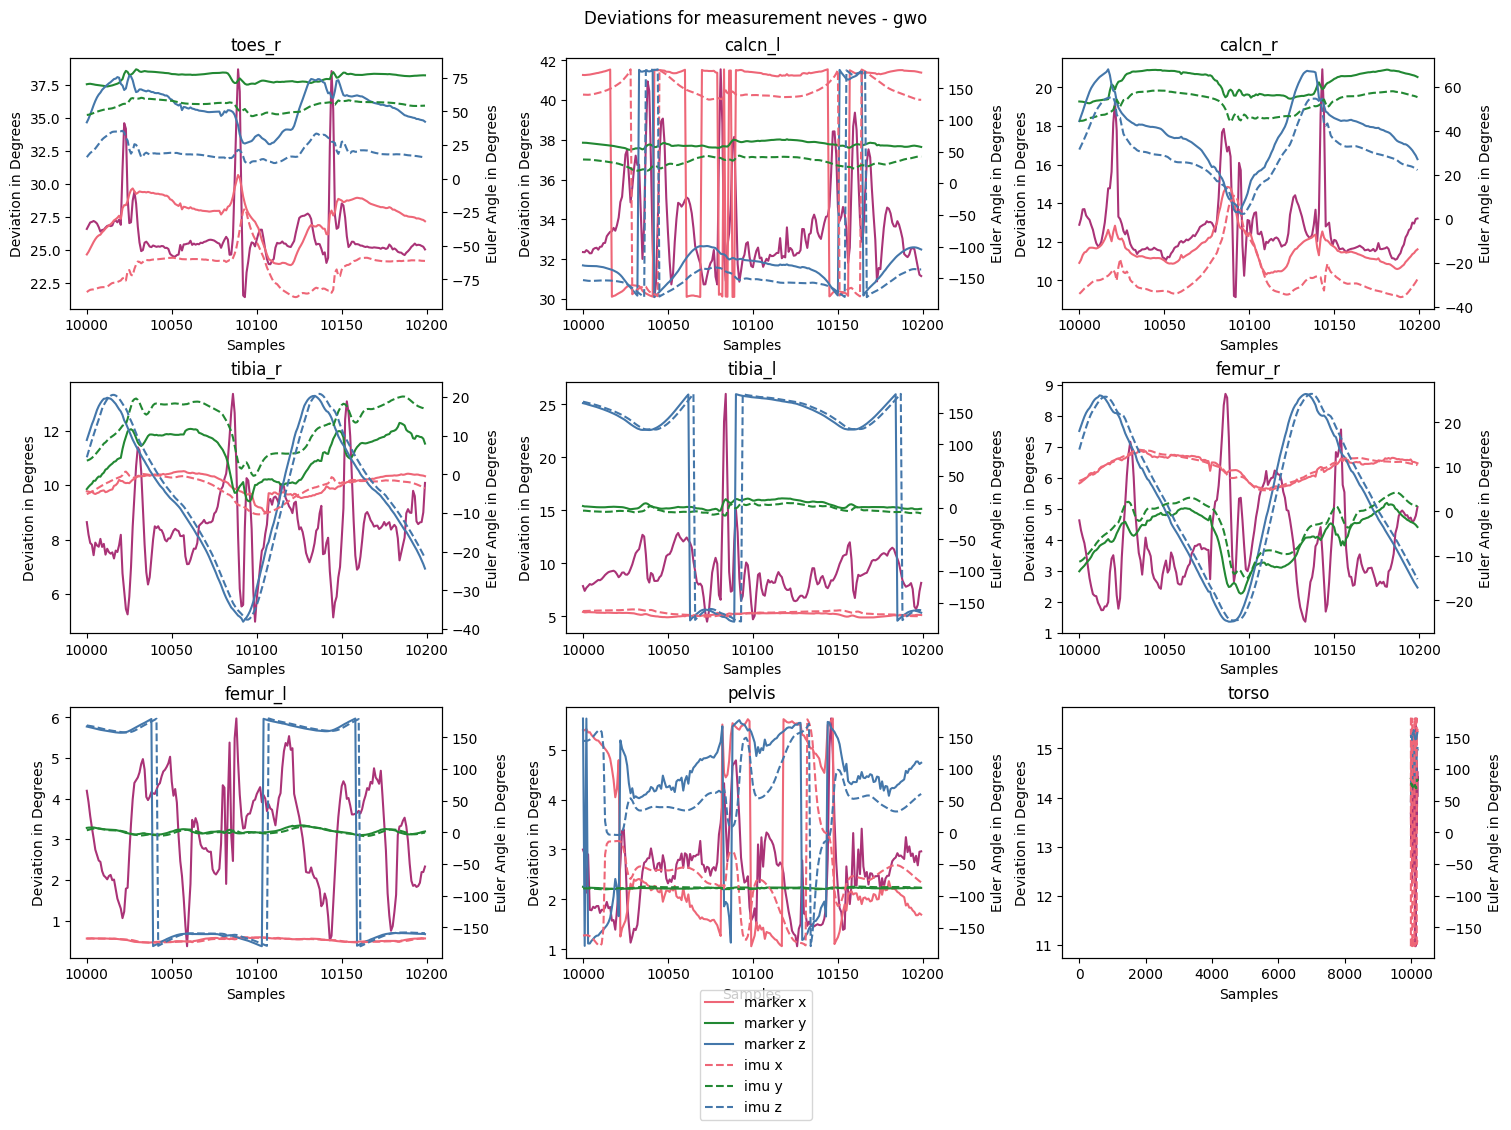

In [69]:

# example ausreiser wegen zeitlichem offset : toes_r, austra, ce, ausreiser 25050, 25150
# example ausreiser wegen qtm, marker verdeckt durch hand: femur_r, austra, ce, ausreiser  11050, 11150
# example verdreht -> julia, femur_r,
plot_euler_angles(data, subject_name, exercise_name, 10000, 10200)

### Analyse max deviation

- tibia l & calcn l sind die besten -> spricht f√ºr offset bei Filter

In [8]:
imu_pos = 'toes_r'

marker_data = read_trc_file(str(data_path / 'ik_imus' / f'marker_data_osim_format_{subject_name}_{exercise_name}.trc'))

toes_data = np.array(data[imu_pos])
max_toes_deviation = np.argmax(data[imu_pos])
print(f'Max deviation at {imu_pos} is at index {max_toes_deviation} with value {data[imu_pos][max_toes_deviation]} ')
marker_data[['R_TOE1_x', 'R_TOE1_y', 'R_TOE1_z', 'R_TOE2_x', 'R_TOE2_y', 'R_TOE2_z','R_TOE3_x', 'R_TOE3_y', 'R_TOE3_z',]].iloc[max_toes_deviation-2: max_toes_deviation+2]

Max deviation at toes_r is at index 25094 with value 55.65757672538128 


R_TOE1_x   R_TOE1_y   R_TOE1_z    R_TOE2_x   R_TOE2_y   R_TOE2_z  \
25092  727.044861  28.724297 -88.231483  706.137573  66.240318 -33.300240   
25093  735.000916  47.610546 -92.798508  707.324585  80.382889 -38.313786   
25094  738.752869  59.967888 -95.169594  705.277466  90.937965 -43.089832   
25095  741.646057  61.746849 -94.573013  706.181824  93.490326 -44.270969   

         R_TOE3_x   R_TOE3_y   R_TOE3_z  
25092  701.123169  71.110138 -82.563736  
25093  697.002747  79.452682 -86.717812  
25094  694.234314  82.057632 -90.368378  
25095  696.642456  83.272308 -91.665710

# Analyse Euler-Angles